### The following techniques will be used in this notebook- 

1. Linear regression <br>
2. Linear regression with polynomial features <br>
3. Lasso regularization (l1)
4. Ridge regularization (l2)
5. ElasticNet regularization (l1 + l2)

In [1]:
'''
    ----------------------------------------------------------------------------------------------
    February 2022
    Dr. Maryam Khanahmadi
    Postdoctoral Researcher
    Wallenberg Center for Quantum Technology (WACQT)
    Chalmers University of Technology
    
    m.khanahmadi94@gmail.com
    Data set used: https://www.kaggle.com/mirichoi0218/insurance
    ----------------------------------------------------------------------------------------------
    
    
    In this notebook we are using the healthcare data set where the 
    price for health insurance is predicted based on the age, sex, BMI, 
    smoking preferences, number of children and region.
    
    
    We plan to employ Linear Regression models such as basic linear regression, 
    linear regression with different polynomial features and use LASSO, Ridge and
    Eleactic Net to come up with a model which best describes the data set.
    
    
    So the work plan is as follows- 
    1. Data exploration and data cleaning.
    2. Label encoding for the relevant object data types.
    3. Check skewness of the data set.
    4. Vanilla linear regression.
    5. Add polynomial features and extract the most suited polynomial for minimum error.
    6. Fine tune the model using LASSO, Ridge and Elastic Net.
''';

In [2]:
# Import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

In [159]:
def encoding(DS, cols):
    '''
    This function takes the data set and column indexes as input which needs to be label encoded.
    There are two possible options- one hot encoding or label encoding
        
        
    Arguments- 
        DS   :  The data set
        cols :  Index of the columns which needs to be encoded
        
        
    Returns-
        df   : Encoded data set 
    '''

    num_of_cols = len(cols)
    le = LabelEncoder()
    for i in range(num_of_cols):
        DS.iloc[:,cols[i]] = le.fit_transform(DS.iloc[:,cols[i]])
    return DS




def LogReg(X_train, Y_train, X_test, Y_test, poly = 1):
    '''
    This function takes the train and test data set and returns the predicted Y values
    and other error metrics such as mean squared error and R squared error.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory
        poly                               : Number of polynomial features, if no input defaults to 1
    
    Returns-
        Y_pred, R2_error, MS_Error, fmodel : Predicted Y, R squared error, mean squared error and the fitted model   

    '''
    
    # Perform basic linear regression     
    if poly == 1:  
        
        s = StandardScaler()
        LR = LinearRegression()
        X_train = s.fit_transform(X_train)
        LR.fit(X_train, Y_train);
        
        Y_pred = LR.predict(s.transform(X_test))
        r2_error = r2_score(np.array(Y_test), Y_pred)
        ms_error = mean_squared_error(np.array(Y_test), Y_pred)
        fmodel = LR

        
    # Linear regression with Polynomial features    
    else:         
        lr = LinearRegression()
        pf = PolynomialFeatures(degree=poly)
        X_train = pf.fit_transform(X_train)
        lr.fit(X_train, Y_train)

        Y_pred = lr.predict(pf.transform(X_test))
        r2_error = r2_score(np.array(Y_test), Y_pred)
        ms_error = mean_squared_error(np.array(Y_test), Y_pred)
        fmodel = lr
          
            
    return Y_pred, r2_error, ms_error, fmodel






def cross_val(X_train, Y_train, X_test, Y_test, poly, regu_type, param_range, cv, ratio=0.5):
    '''
    This function perfoms Lasso, Ridge or ElasticNet regression and the best model is selected 
    using cross validations.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory
        poly                               : Number of polynomial features
        regu_type                          : Regularization type: LassoCV/RidgeCV/ElasticNetCV
        param_range                        : Range for alphas
        cv                                 : number of cross validation
        ratio                              : l1 and l2 ratio if ElasticNetCV is selected as regu_type

        
    Returns-
        Y_pred                             : Predicted Y
        R2_error                           : R squared error
        MS_Error                           : mean squared error
        fmodel                             : fitted model
                                             
                                                      
    '''
    # Perform Lasso regularization
    if regu_type == 'LassoCV':           
        pf = PolynomialFeatures(degree=poly)
        alpha = param_range

        Lasso_CV = LassoCV(alphas=alpha,
                           max_iter=1e6,
                           cv=cv).fit(pf.fit_transform(X_train), Y_train)
        Y_pred = Lasso_CV.predict(pf.transform(X_test))
        ms_error = mean_squared_error(Y_pred, Y_test)
        r2_error = r2_score(Y_pred, Y_test)
        fmodel = Lasso_CV

        
    # Perform Ridge regularization   
    elif regu_type == 'RidgeCV':         
        pf = PolynomialFeatures(degree=poly)
        alpha = param_range

        Ridge_CV = RidgeCV(alphas=alpha,
                           cv=cv).fit(pf.fit_transform(X_train), Y_train)
        Y_pred = Ridge_CV.predict(pf.transform(X_test))
        ms_error = mean_squared_error(Y_pred, Y_test)
        r2_error = r2_score(Y_pred, Y_test)
        fmodel = Ridge_CV

        
    # Perform ElasticNet regularization    
    elif regu_type == 'ElasticNetCV':         
        pf = PolynomialFeatures(degree=poly)
        alpha = param_range

        ElasticNet_CV = ElasticNetCV(alphas=alpha, l1_ratio=ratio, 
                          cv=cv).fit(pf.fit_transform(X_train), Y_train)

        Y_pred = ElasticNet_CV.predict(pf.transform(X_test))
        ms_error = mean_squared_error(Y_pred, Y_test)
        r2_error = r2_score(Y_pred, Y_test)
        fmodel = ElasticNet_CV

    
    # Error message in case none of the regularization techniques match     
    else:
        print("Check regularization options: LassoCV, RidgeCV, ElasticNetCV")
        Y_pred = []
        r2_error, ms_error, best = '#ERROR', '#ERROR', '#ERROR'
    
    
    return Y_pred, r2_error, ms_error, fmodel

### Data exploration and feature engineering

1. Explore the data set, understand the features and identify the predictable feature. <br>
2. Remove the unnecessary features from the data set. <br>
3. Clean the data set of any outliers. <br>
4. Check the distribution of the data set and investigate if transformation is necessary. <br>
5. Label encode the object datatypes
6. Visualize the data set

In [47]:
datafile = "insurance.csv"
df = pd.read_csv(datafile, index_col=False)
df.head(8)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560


In [48]:
# This checks the number of NaN values in each columns
print("Number of NaN values in each feature columns- ")
df.isnull().sum()

Number of NaN values in each feature columns- 


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [49]:
# This checks the counts, mean, min, max of each features in each columns
# No inconsistency can be observed in the feature columns
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [50]:
'''
    Check the columns which needs label encoding.
    Here, 'sex','smoker' and 'region' are of data type object.
    The medical costs billed by health insurance perhaps depend on 'sex' and 'smoker'.
    However dependency of 'region' on the medical bills is unclear and we shall check the accuracy
    of our regression model both with and without the 'region' feature to understand better.
    acc

'''

# Indices of the columns with data type 'object'
cols = np.where(df.dtypes == object)[0]
df = encoding(df, cols)

# Vefifying the label encoding
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [75]:
# Features which will be used for prediction  
feature_cols = df.columns[:6]

# Split the data into Train and Test set
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_cols], df['charges'], test_size=0.3, random_state=11111)

# Check the number of train and test portions of the data set
print("Number of training sets:", len(X_train))
print("Number of test sets:", len(X_test))

Number of training sets: 936
Number of test sets: 402


### LINEAR REGRESSION

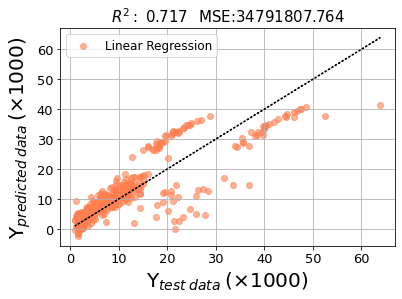

In [76]:
Y_pred_LR, r2_error_LR, ms_error_LR, model_LR = LogReg(X_train, Y_train, X_test, Y_test)

# Visualize the fit of the model
plt.grid('on')
plt.scatter(Y_test/1000, Y_pred_LR/1000, marker = 'o', alpha = 0.6, color='coral', label = 'Linear Regression')
plt.plot(Y_test/1000,  Y_test/1000,'k:', linewidth = 1.5)
plt.ylabel(r'Y$_{predicted\:data}\:(\times 1000)$', fontsize = 20)
plt.xlabel(r'Y$_{test\:data}\:(\times1000)$', fontsize = 20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('$R^2:$ '+ str(np.round(r2_error_LR,3))+ r'$\:\:$ MSE:'+ str(np.round(ms_error_LR,3)), fontsize = 15)
plt.legend(fontsize = 12)

In [77]:
# Print the error metric
print('R2 error using Linear Regression is :', np.round(r2_error_LR,3))
print('Mean squared error using Linear Regression is :', np.round(ms_error_LR,3))

R2 error using Linear Regression is : 0.717
Mean squared error using Linear Regression is : 34791807.764


In [78]:
'''
    From the test vs prediction plot above, it can be seen that for some of the 
    cases, the predicted Y value (medical bill from insurance) is negative.
    
    This is unusual and hence here we would check if there is any particular 
    trend for those cases.

'''
# Check which predicted values are negative
rows_negative = np.where(Y_pred_LR<0)

# Collect the indices so that the data extracted from the data frame
indices = Y_test.iloc[rows_negative[0]].index

# Print those rows from the original data set
df.iloc[indices,:]

,age,sex,bmi,children,smoker,region,charges
410,19,1,17.480,0,0,1,1621.34020
172,18,1,15.960,0,0,0,1694.79640
940,18,1,23.210,0,0,2,1121.87390
1295,20,1,22.000,1,0,3,1964.78000
359,18,0,20.790,0,0,2,1607.51010
1027,23,1,18.715,0,0,1,21595.38229
232,19,0,17.800,0,0,3,1727.78500
747,19,1,21.755,0,0,1,1627.28245
1212,18,1,21.470,0,0,0,1702.45530


In [80]:
'''

    Since a linear regression technique is used, and some of the features such as 
    'sex', 'children', 'smoker' and 'region' can take values 0, the predicted Y values
    for those cases can often go to small values and even negative since we are fitting 
    the data in a straight line with no polynomial dependencies.
    

    To understand this, we first check the coefficients from the fitted model which will
    provide ingights into which features have maximum weighage.
    
    Having lower values for those features may lead to negtive prediction of Y.
    
'''

# Create a data frame to check the coefficients for each of the factors in the model.
temp_data = {'features':  df.columns[0:6],
        'coefficients': model_LR.coef_,
        }
pd.DataFrame(temp_data).sort_values(by=['coefficients'], ascending = False)

,features,coefficients
4,smoker,10072.207571
0,age,3645.984624
2,bmi,1932.011228
3,children,630.598395
1,sex,25.084267
5,region,-441.196769


In [88]:
'''
    From the above data frame it is evident that the features 'smoker', 'age' and 'bmi'
    plays a major role in predicting the Y values.
    
    Now we can filter the data frame with the following conditions and check if the list matches- 
    1. smoker = 0
    2. age < 20
    3. bmi < 20
    4. children = 0


'''
df.loc[(df['smoker']==0) & (df['age']<=22) & (df['bmi']<23) & (df['children']==0)]

,age,sex,bmi,children,smoker,region,charges
35,19,1,20.425,0,0,1,1625.43375
172,18,1,15.960,0,0,0,1694.79640
232,19,0,17.800,0,0,3,1727.78500
295,18,1,22.990,0,0,0,1704.56810
359,18,0,20.790,0,0,2,1607.51010
410,19,1,17.480,0,0,1,1621.34020
584,19,1,20.700,0,0,3,1242.81600
681,19,1,20.300,0,0,3,1242.26000
747,19,1,21.755,0,0,1,1627.28245
882,21,0,22.135,0,0,0,2585.85065


In [89]:
indices_condition = df.loc[(df['smoker']==0) & (df['age']<=20) & (df['bmi']<23) & (df['children']==0)].index
indices_predict = indices

# print the values where the above conditions matched with the cases where the predicted model returned a negative value
df.iloc[np.intersect1d(indices_condition,indices_predict),:]

,age,sex,bmi,children,smoker,region,charges
172,18,1,15.960,0,0,0,1694.79640
232,19,0,17.800,0,0,3,1727.78500
359,18,0,20.790,0,0,2,1607.51010
410,19,1,17.480,0,0,1,1621.34020
747,19,1,21.755,0,0,1,1627.28245
1212,18,1,21.470,0,0,0,1702.45530


As can be seen from the table above that we could correctly predict 6 out of 10 cases where the model predicted negative value of the insurance charge. 
This was caused due to lower values of the features which are most heavily weighted in the model such as smoker, age and bmi.
This can be tackled as we start incorporating polynomial features in the model in the next section.

### Linear regression with POLYNOMIAL FEATURES

In [90]:
# First we would like to check how many polynomial features describes the test data with minimum error.
# We can estimate that from the R2 error and mean squared error.

r2_error_poly = []
ms_error_poly = []
for pfeatures in range(1,6):
    
    result = LogReg(X_train, Y_train, X_test, Y_test, poly = pfeatures)   
    r2_error_poly.append(result[1])
    ms_error_poly.append(result[2])

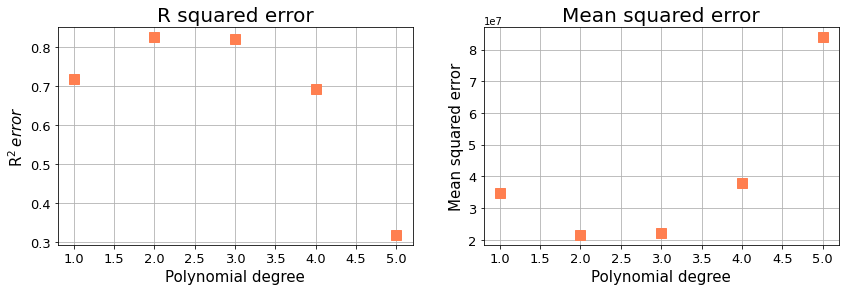

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(range(1,6), r2_error_poly, 's', markersize = 10, markerfacecolor='coral', markeredgecolor ='coral')
axs[0].set_ylabel(r'R$^2\: error$', fontsize = 15)
axs[0].set_xlabel('Polynomial degree', fontsize = 15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].grid('on')
axs[0].set_title("R squared error", fontsize = 20)


axs[1].plot(range(1,6), ms_error_poly, 's', markersize = 10, markerfacecolor='coral', markeredgecolor ='coral')
axs[1].set_ylabel('Mean squared error', fontsize = 15)
axs[1].set_xlabel('Polynomial degree', fontsize = 15)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].tick_params(axis='y', labelsize=13)
axs[1].grid('on')
axs[1].set_title("Mean squared error", fontsize = 20);

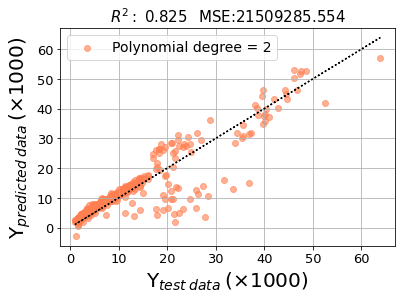

In [92]:
'''
    From the above analysis it is clear that the error rate decreases as we incorporate the polynomial features.
    It turns out that with degree = 1, the linear regression model is bit too simple and for degree >2 , the 
    error rates start increasing due to overfitting.
    
    Therefore the most appropriate would be a linear regression model with degree 2.
    
    To fine tune the model, in the next section we would incorporate LASSO, Ridge and ElasticNet features.
'''

# Using polynomial degree 2 to fit the data set.
Y_pred_poly2, r2_error_poly2, ms_error_poly2, model_poly2 = LogReg(X_train, Y_train, X_test, Y_test, poly = 2) 


# Visualize the fit of the model
plt.grid('on')
plt.scatter(Y_test/1000, Y_pred_poly2/1000, marker = 'o', alpha = 0.6, color='coral', label = 'Polynomial degree = 2')
plt.plot(Y_test/1000,  Y_test/1000,'k:', linewidth = 1.5)
plt.ylabel(r'Y$_{predicted\:data}\:(\times 1000)$', fontsize = 20)
plt.xlabel(r'Y$_{test\:data}\:(\times1000)$', fontsize = 20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('$R^2:$ '+ str(np.round(r2_error_poly2,3))+ r'$\:\:$ MSE:'+ str(np.round(ms_error_poly2,3)), fontsize = 15)
plt.legend(fontsize = 14);

In [103]:
'''
    It would be interesting to check which of the polynomial features play the most important role
    in determining the charges.
    
    As can be seen from the table below, polynomial factors such as (bmi, smoker), (sex, smoker) are among
    the top 5 factors determining the price of the health insurance.

'''
pf = PolynomialFeatures(degree=2)
pf.fit_transform(X_train)
temp_data = {'features':  pf.get_feature_names(df.columns),
        'coefficients': model_poly2.coef_,
        }
pd.DataFrame(temp_data).sort_values(by=['coefficients'], ascending = False).head(10)

,features,coefficients
4,children,1562.507435
20,bmi smoker,1457.888607
3,bmi,668.815052
16,sex smoker,298.819228
27,region^2,58.889737
8,age sex,34.192715
14,sex bmi,25.683698
12,age region,13.044816
7,age^2,3.683434
19,bmi children,1.830302


In [ ]:
'''
    Now one can use the Polynomial degree = 3 and fine tune the effects of polynomial features using 
    different types of regularization such as LASSO, Ridge and the combination of the both- ElasticNet.

'''

### Polynomial degree = 3 and LASSO regularization

In [128]:
# Range in which we want to search for the best model
param_range = np.geomspace(0.01, 1, num=10)
# Number of cross validation
cv = 2
poly = 3
import warnings
warnings.filterwarnings('ignore', module='sklearn')
Y_pred_lasso, r2_error_lasso, ms_error_lasso, fmodel_lasso = cross_val(X_train, Y_train, X_test, Y_test, poly, 'LassoCV', param_range, cv, ratio=0.5)

In [134]:
print("R2 error using degree = 3 and LASSO is", np.round(r2_error_lasso,3))
print("Mean squared error using degree = 3 and LASSO is", np.round(ms_error_lasso,3))
print("The optimal value of alpha is: ", fmodel_lasso.alpha_)

R2 error using degree = 3 and LASSO is 0.811
Mean squared error using degree = 3 and LASSO is 21908472.807
The optimal value of alpha is:  1.0


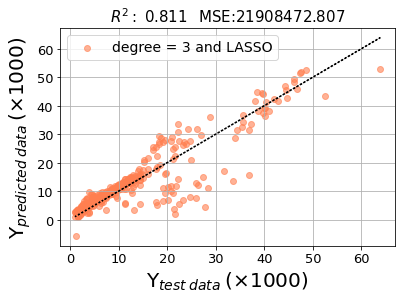

In [135]:
# Visualize the fit of the model
plt.grid('on')
plt.scatter(Y_test/1000, Y_pred_lasso/1000, marker = 'o', alpha = 0.6, color='coral', label = 'degree = 3 and LASSO')
plt.plot(Y_test/1000,  Y_test/1000,'k:', linewidth = 1.5)
plt.ylabel(r'Y$_{predicted\:data}\:(\times 1000)$', fontsize = 20)
plt.xlabel(r'Y$_{test\:data}\:(\times1000)$', fontsize = 20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('$R^2:$ '+ str(np.round(r2_error_lasso,3))+ r'$\:\:$ MSE:'+ str(np.round(ms_error_lasso,3)), fontsize = 15)
plt.legend(fontsize = 14);

### Polynomial degree = 3 and Ridge regularization

In [163]:
# Range in which we want to search for the best model
param_range = np.geomspace(0.01, 1, num=10)
# Number of cross validation
cv = 2
poly = 3
import warnings
warnings.filterwarnings('ignore', module='sklearn')
Y_pred_ridge, r2_error_ridge, ms_error_ridge, fmodel_ridge = cross_val(X_train, Y_train, X_test, Y_test, poly, 'RidgeCV', param_range, cv, ratio=0.5)

In [164]:
print("R2 error using degree = 3 and Ridge is", np.round(r2_error_ridge,3))
print("Mean squared error using degree = 3 and Ridge is", np.round(ms_error_ridge,3))
print("The optimal value of alpha is: ", np.round(fmodel_ridge.alpha_,5))

R2 error using degree = 3 and Ridge is 0.811
Mean squared error using degree = 3 and Ridge is 21911816.598
The optimal value of alpha is:  0.12915


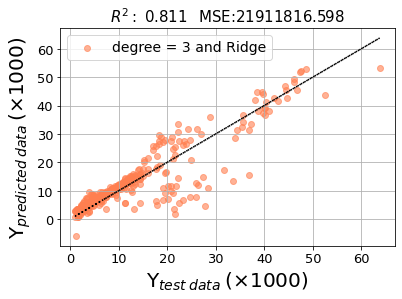

In [165]:
# Visualize the results with the most optmimal value of alpha
param_range = [fmodel_ridge.alpha_]
Y_pred_ridge, r2_error_ridge, ms_error_ridge, fmodel_ridge = cross_val(X_train, Y_train, X_test, Y_test, poly, 'RidgeCV', param_range, cv, ratio=0.5)



plt.grid('on')
plt.scatter(Y_test/1000, Y_pred_ridge/1000, marker = 'o', alpha = 0.6, color='coral', label = 'degree = 3 and Ridge')
plt.plot(Y_test/1000,  Y_test/1000,'k:', linewidth = 1.5)
plt.ylabel(r'Y$_{predicted\:data}\:(\times 1000)$', fontsize = 20)
plt.xlabel(r'Y$_{test\:data}\:(\times1000)$', fontsize = 20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('$R^2:$ '+ str(np.round(r2_error_ridge,3))+ r'$\:\:$ MSE:'+ str(np.round(ms_error_ridge,3)), fontsize = 15)
plt.legend(fontsize = 14);

### Polynomial degree = 3 and ElasticNet regularization


In [190]:
# Range in which we want to search for the best model
param_range = np.geomspace(0.01, 1, num=10)
# Number of cross validation
cv = 2
poly = 3
import warnings
warnings.filterwarnings('ignore', module='sklearn')
Y_pred_ENet, r2_error_ENet, ms_error_ENet, fmodel_ENet = cross_val(X_train, Y_train, X_test, Y_test, poly, 'ElasticNetCV', param_range, cv, ratio=0.5)

In [191]:
print("R2 error using degree = 3 and ENet is", np.round(r2_error_ENet,3))
print("Mean squared error using degree = 3 and ENet is", np.round(ms_error_ENet,3))
print("The optimal value of alpha is: ", np.round(fmodel_ENet.alpha_,5))

R2 error using degree = 3 and ENet is 0.813
Mean squared error using degree = 3 and ENet is 21399323.993
The optimal value of alpha is:  1.0


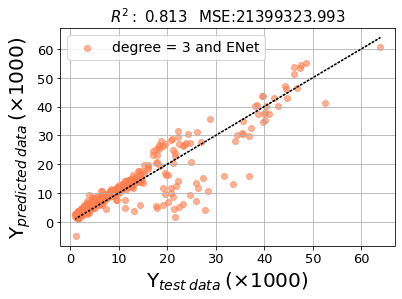

In [192]:
# Visualize the results with the most optmimal value of alpha
param_range = [fmodel_ENet.alpha_]
Y_pred_ridge, r2_error_ridge, ms_error_ridge, fmodel_ridge = cross_val(X_train, Y_train, X_test, Y_test, poly, 'RidgeCV', param_range, cv, ratio=0.5)



plt.grid('on')
plt.scatter(Y_test/1000, Y_pred_ENet/1000, marker = 'o', alpha = 0.6, color='coral', label = 'degree = 3 and ENet')
plt.plot(Y_test/1000,  Y_test/1000,'k:', linewidth = 1.5)
plt.ylabel(r'Y$_{predicted\:data}\:(\times 1000)$', fontsize = 20)
plt.xlabel(r'Y$_{test\:data}\:(\times1000)$', fontsize = 20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('$R^2:$ '+ str(np.round(r2_error_ENet,3))+ r'$\:\:$ MSE:'+ str(np.round(ms_error_ENet,3)), fontsize = 15)
plt.legend(fontsize = 14);

In [198]:
# Create a DataFrame to highlight all the errors

print("SUMMARY of THE ANALYSIS-")
print("------------------------------------------------")

Dx = {'Linear Regression':[r2_error_LR, ms_error_LR],'Polynomial degree = 2':[r2_error_poly2, ms_error_poly2], 
      'Degree = 3 and LASSO':[r2_error_lasso, ms_error_lasso], 'Degree = 3 and Ridge':[r2_error_ridge, ms_error_ridge], 
      'Degree = 3 and Elastic Net':[r2_error_ENet, ms_error_ENet]}
Dx = pd.DataFrame(data=Dx).T
Dx.rename(columns={0: "$R^2$ error", 1: "Mean squared error"})

SUMMARY of THE ANALYSIS-
------------------------------------------------


,$R^2$ error,Mean squared error
Linear Regression,0.717163,3.479181e+07
Polynomial degree = 2,0.825142,2.150929e+07
Degree = 3 and LASSO,0.810555,2.190847e+07
Degree = 3 and Ridge,0.813615,2.172156e+07
Degree = 3 and Elastic Net,0.812927,2.139932e+07


### The following conclusions can be drawn from the above analysis- 

1. Linear regression with polynomial features of degree = 2 is the best fit model for this data set. <br>
2. LASSO, Ridge and Elastic Net can be used to regularize the l1 and l2 penalties but there is no significant improvement in the error rates. <br>
3. The top 3 factors determining the price of health insurance are - (a) Number of children (b) (Smoker, BMI) and (c) BMI